### I. **Introduction**

*Business Problem*
<br><br>
 In the context of telecommunications(telco) companies, customer churn poses a significant challenge. It refers to the rate at which customers discontinue their services, such as canceling phone plans or switching providers. Telcos must address this issue strategically to retain existing customers, reduce revenue loss, and maintain market competitiveness.
 
*Business Quesitons*
<br>
To understand customer churn and prevent it, the classification machine learning project aims to address the following questions:
<br>
1. What characterirstics do customers who churn (unsubscribe) have?
2. What characterirstics do customers who have not unsubscribe have?
3. Based on the results of the classification model, what can be done to prevent telco customers from churning?

### II. **Dataset Description**


*A. Predictor Variables*
- customerId - unique identifier for customer
- gender - customer gender male/female
- SeniorCitizen	- indicator if customer is senior citizent 0/1
- Partner - Whether the customer has a partner or not (Yes, No)
- Dependents - Whether the customer has dependents or not (Yes, No)
- tenure - Number of months the customer has stayed with the company
- PhoneService - Whether the customer has a phone service or not (Yes, No)
- MultipleLines	- Whether the customer has multiple lines or not (Yes, No, No phone service)
- InternetService - Customer’s internet service provider (DSL, Fiber optic, No)
- OnlineSecurity - Whether the customer has online security or not (Yes, No, No internet service)
- OnlineBackup - Whether the customer has online backup or not (Yes, No, No internet service)
- DeviceProtection - Whether the customer has device protection or not (Yes, No, No internet service)
- TechSupport - Whether the customer has tech support or not (Yes, No, No internet service)
- StreamingTV - Whether the customer has streaming TV or not (Yes, No, No internet service)
- StreamingMovies - Whether the customer has streaming movies or not (Yes, No, No internet service)
- Contract - The contract term of the customer (Month-to-month, One year, Two year)
- PaperlessBilling - Whether the customer has paperless billing or not (Yes, No)
- PaymentMethod	- The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
- MonthlyCharges - The amount charged to the customer monthly
- TotalCharges - The total amount charged to the customer

*B. Target Variable*
- Churn - Whether the customer churned or not (Yes or No)

### III. **Importing Libraries**

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

import shap

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### IV. **Data Preprocessing**

In [2]:
churn_df = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
churn_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
model_data = churn_df.copy(deep=True)

# Remove customer ID since it is not important in the model
model_data.drop("customerID", inplace=True, axis=1)

# Convert gender to numeric encoding
model_data.gender = model_data.gender.apply(lambda x: 1 if x == "Female" else 0)

# Convert SeniorCitizen, Partner, Dependents, PhoneService, PaperlessBilling, Churn, etc to numeric encoding
for feature in ['SeniorCitizen', 'Partner', 
          'Dependents', 'PhoneService', 
          'PaperlessBilling', 'Churn',
          'MultipleLines', 'OnlineSecurity',
          'OnlineBackup', 'DeviceProtection',
          'TechSupport', 'StreamingTV',
          'StreamingMovies']:
    model_data[feature] = model_data[feature].apply(lambda x: 1 if x == "Yes" else 0)

# Convert TotalCharges to float
model_data.TotalCharges = pd.to_numeric(model_data.TotalCharges, errors='coerce')
model_data.TotalCharges = model_data.TotalCharges.fillna(value=-1)

# One hot encode features with multiple categories
multi_categorical_features = ['InternetService', 'Contract', 'PaymentMethod']
encoder = OneHotEncoder(handle_unknown='ignore')
encoded_multi_feat = encoder.fit_transform(model_data[multi_categorical_features])
encoded_multi_feat_df = pd.DataFrame(encoded_multi_feat.todense(), columns=encoder.get_feature_names())

# Replace multi categorical features with one-hot encoded features
model_data.drop(multi_categorical_features, axis=1, inplace=True)
model_data = pd.concat([model_data, encoded_multi_feat_df], axis=1)
model_data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,x0_DSL,x0_Fiber optic,x0_No,x1_Month-to-month,x1_One year,x1_Two year,x2_Bank transfer (automatic),x2_Credit card (automatic),x2_Electronic check,x2_Mailed check
0,1,0,1,0,1,0,0,0,1,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,0,0,0,34,1,0,1,0,1,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0,0,0,0,2,1,0,1,1,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,0,0,0,45,0,0,1,0,1,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,1,0,0,0,2,1,0,0,0,0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [5]:
numeric_df = model_data[['tenure', 'MonthlyCharges', 'TotalCharges']]
numeric_df.describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.732742
std,24.559481,30.090047,2266.796041
min,0.000000,18.250000,-1.000000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


### V. **Data Visualization**

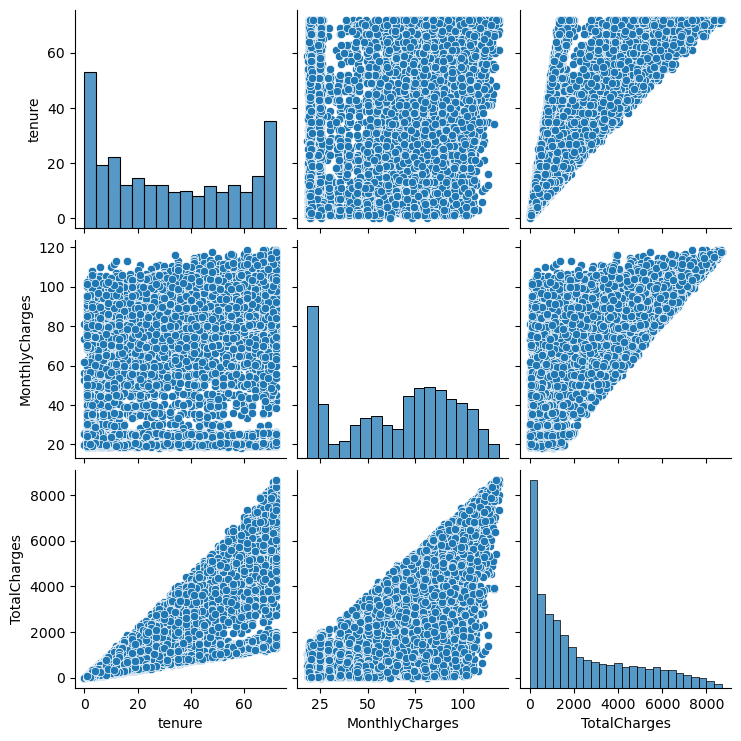

In [6]:
sns.pairplot(numeric_df)

It is observed that `MonthlyCharges` and `tenure` exhibit a positive relationship with `TotalCharges`. This is because a longer tenure would accrue more charges, thus resulting to a higher total charge. On the other hand, a higher monthly bill would eventually result to a higher total charge because of the accruing higher monthly bill.

In [7]:
corr = numeric_df.corr().round(2)
corr

,tenure,MonthlyCharges,TotalCharges
tenure,1.00,0.25,0.83
MonthlyCharges,0.25,1.00,0.65
TotalCharges,0.83,0.65,1.00


In [8]:
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
df_corr_viz = corr.mask(mask).dropna(how='all').dropna(axis='columns', how='all')
fig = px.imshow(df_corr_viz, text_auto=True, color_continuous_scale="OrRd").update_xaxes(showgrid=False).update_yaxes(showgrid=False)
fig.show()

From the correlation heat map, it can seen that `TotalCharges` has a high correlation with `tenure` and `MonthlyCharges` with `tenure` having the highest correlation with `TotalCharges`.

In [9]:
X = model_data.drop("Churn", axis=1)
y = model_data["Churn"]

In [10]:
model_data.Churn.value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

### VI. **Modeling**

In [11]:
# Splitting of Train and Test dataset for Modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#### Random Forest Classifier


The Random Forest Classifier is an ensemble learning method that builds multiple decision trees and merges them to obtain a more accurate and stable prediction. It operates by creating a 'forest' of random decision trees during training and outputs the class that is the mode of the classes (classification) of the individual trees. This technique reduces overfitting and improves the model's generalization capabilities by averaging the predictions of multiple trees. The RandomizedSearchCV is used to find the optimal Random Forest hyperparameters.

In [12]:
# Hyperparameter space for the Random Search
param_grid = {
    "n_estimators": list(range(100, 150, 10)),
    "max_depth": list(range(5, 50, 5)),
    "min_samples_split": np.arange(.1, .6, .1),
    "min_samples_leaf": np.arange(.1, .6, .1),
    "max_features": np.arange(.1, .6, .1)
}

clf = RandomForestClassifier() # Initialize Random Forest CLassifier Model
clf_grid = RandomizedSearchCV(clf, param_grid, n_iter=25) # Run Random Search for 25 different hyperparameter combinations
clf_grid.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=25,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30, 35,
                                                      40, 45],
                                        'max_features': array([0.1, 0.2, 0.3, 0.4, 0.5]),
                                        'min_samples_leaf': array([0.1, 0.2, 0.3, 0.4, 0.5]),
                                        'min_samples_split': array([0.1, 0.2, 0.3, 0.4, 0.5]),
                                        'n_estimators': [100, 110, 120, 130,
                                                         140]})

In [13]:
# Extract the Random Forest Model with best hyperparameter combinations
best_rf = clf_grid.best_estimator_ 
best_rf

RandomForestClassifier(max_depth=15, max_features=0.5, min_samples_leaf=0.1,
                       min_samples_split=0.1)

In [14]:
y_pred = best_rf.predict(X_test)

In [15]:
# Check the performance of the classification model using the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1460   92]
 [ 364  197]]
              precision    recall  f1-score   support

           0       0.80      0.94      0.86      1552
           1       0.68      0.35      0.46       561

    accuracy                           0.78      2113
   macro avg       0.74      0.65      0.66      2113
weighted avg       0.77      0.78      0.76      2113



Based on the confusion matrix, the the Random Forest Classifer has classified 1533 true positives, 19 false positves, 476 false negatives, and 85 true negative predictions. It is shown that the model can predict true churn(1) from all the predicted churn really well having a precision score of 0.82, however falling behind with predicting true churn from all the actual churn with a recall of 0.15. On the other hand, the model's performance for predicting not-churn(0) out of all the predicted not-churn is good, having a precision of 0.76. The model performed superbly in predicting not-churn(0) from all the actual not-churn, garnering a recall of 0.99. Overall, by basing on the f1 score metric, which the harmonic mean of presion and recall, the Random Forest Classifier model classifies not-churn(0) better than churn(1) with an overall average f1 score of 0.56.

### VII. **SHAP (SHapley Additive exPlanations)**

SHAP (SHapley Additive exPlanations) is a unified framework for interpreting the predictions of machine learning models. It uses concepts from cooperative game theory to assign each feature an importance value for a particular prediction, ensuring a fair distribution of contribution among features. SHAP values provide a consistent and accurate explanation by considering the impact of all possible feature combinations.

#### SHAP Summary Plot

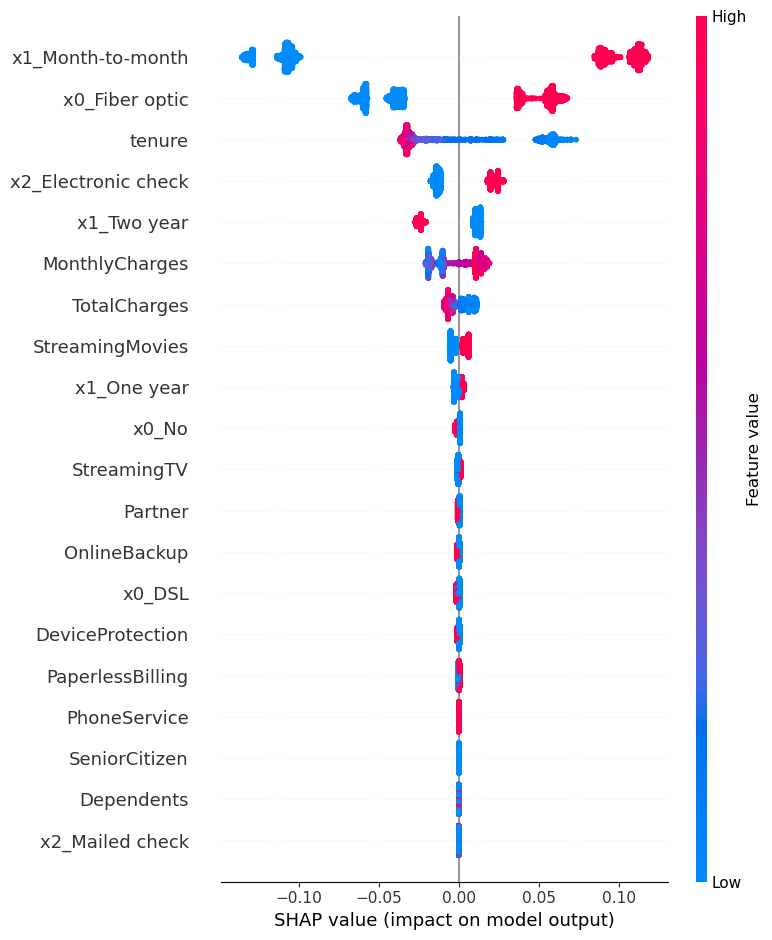

In [16]:
shap.initjs()
samples = X_train
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(samples, approximate=False, check_additivity=False)

shap.summary_plot(shap_values[:,:,1], samples)

Presented in the SHAP summary plot above are the top 20 features that significantly influenced the Random Forest classification model. The `Month-to-month` feature achieved the highest SHAP value, which means that it is the feature that has the greatest impact on the model.

#### SHAP Waterfall Plot (Horizontal Pareto Chart)

In [17]:
def make_shap_waterfall_plot(shap_values, features, num_display=20):
    '''
    A function for building SHAP waterfall plot which will be used to visualize the most important features in a descending order.

        Parameters:
        shap_values (list): SHAP values obtained from a model
        features (pd.DataFrame): a list of features used in a model
        num_display (int): number of features to display

        Returns:
        matplotlib.pyplot plot: SHAP waterfall plot
    '''

    column_list = features.columns
    feature_ratio = (np.abs(shap_values).sum(0) / np.abs(shap_values).sum()) * 100
    column_list = column_list[np.argsort(feature_ratio)[::-1]]
    feature_ratio_order = np.sort(feature_ratio)[::-1]
    cum_sum = np.cumsum(feature_ratio_order)
    column_list = column_list[:num_display]
    feature_ratio_order = feature_ratio_order[:num_display]
    cum_sum = cum_sum[:num_display]

    num_height = 0
    if (num_display >= 20) & (len(column_list) >= 20):
        num_height = (len(column_list) - 20) * 0.4

    fig, ax1 = plt.subplots(figsize=(8, 8  + num_height))
    ax1.plot(cum_sum[::-1], column_list[::-1], c='blue', marker='o')
    ax2 = ax1.twiny()
    ax2.barh(column_list[::-1], feature_ratio_order[::-1], alpha=0.6)

    ax1.grid(True)
    ax2.grid(False)
    ax1.set_xticks(np.arange(0, round(cum_sum.max(), -1)+1, 10))
    ax2.set_xticks(np.arange(0, round(feature_ratio_order.max(), -1)+1, 10))
    ax1.set_xlabel('Cumulative Ratio')
    ax2.set_xlabel('Composition Ratio')
    ax1.tick_params(axis="y", labelsize=13)
    plt.ylim(-1, len(column_list))
    fig.show()

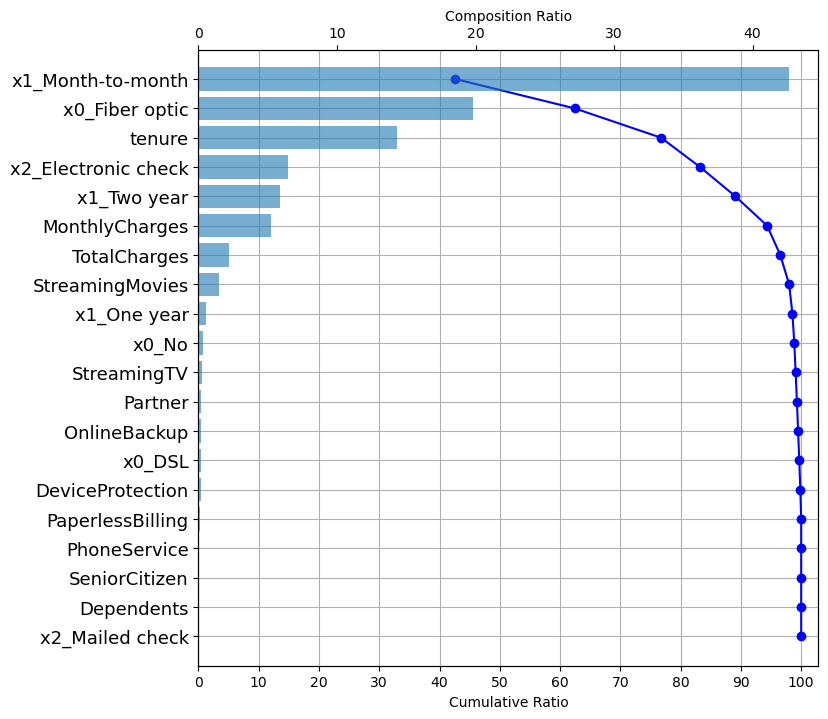

In [18]:
make_shap_waterfall_plot(shap_values[:,:,1], samples)

It can be seen in the waterfall plot above that `Month-to-month` contract term explains more than **40%** of the explainability of the model prediction for customer churn.

#### Dependence Plots

In [19]:
important_features = ['x1_Month-to-month', 'tenure', 'x0_Fiber optic', 'x2_Electronic check']
less_important_features = ['MonthlyCharges', 'x1_Two year', 'x1_One year', 'PaperlessBilling', 'x0_No', 'TotalCharges']

*Dependence Plots for Top 4 Important Features*

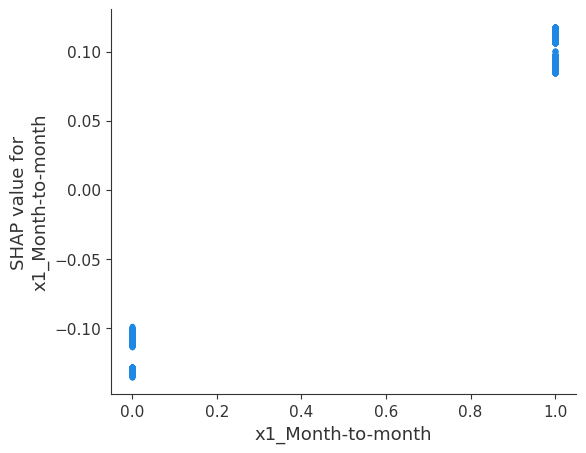

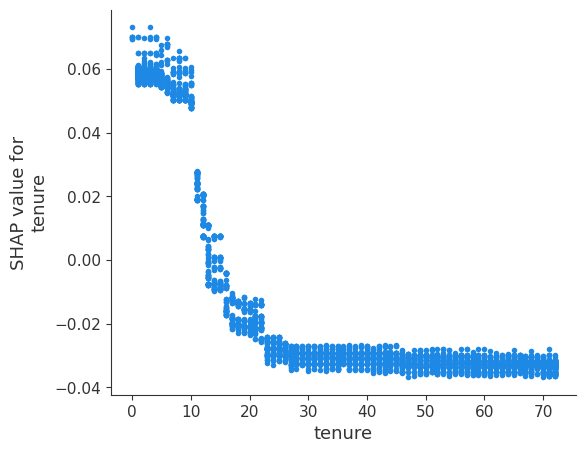

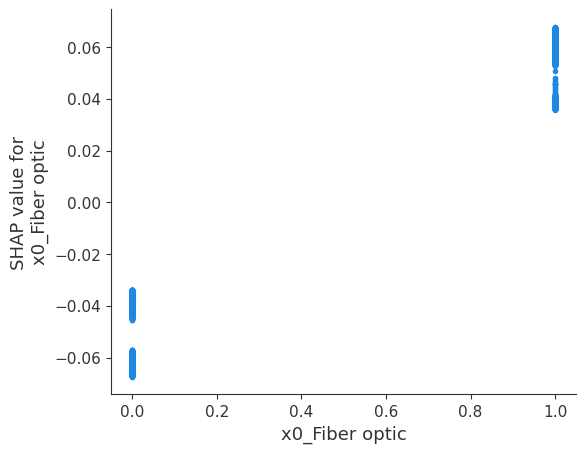

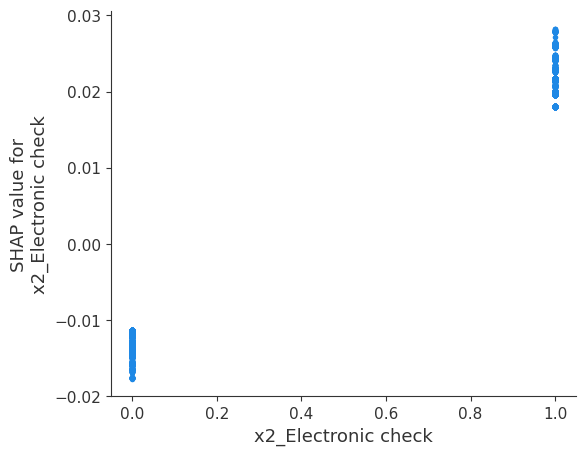

In [20]:
for feature in important_features:
    shap.dependence_plot(feature, shap_values[:,:,1], samples, interaction_index=None)

Based on the dependence plots of the top 1 to 4 most important features, the customers who churn have the following main characteristics:
- In a month-to-month contract term
- Tenure is less than 10 years
- Internet service provider is fiber optic
- Payment method is electronic check

*Dependence Plots for Top 5 to 10 Important Features*

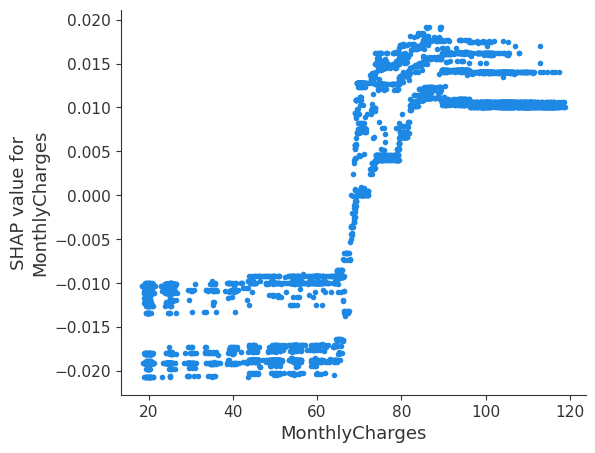

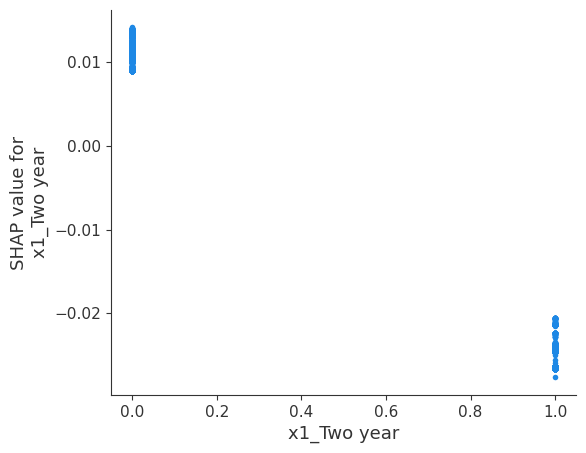

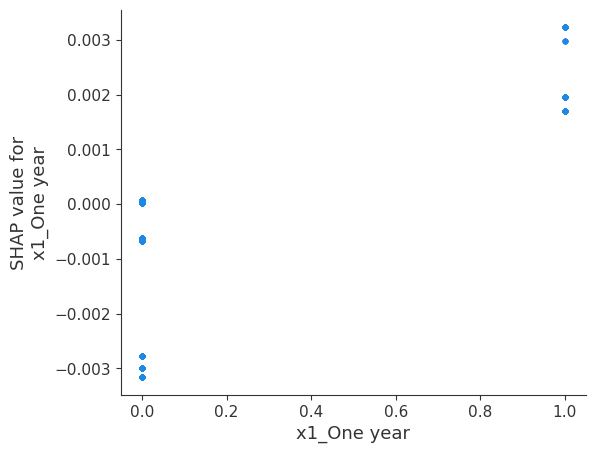

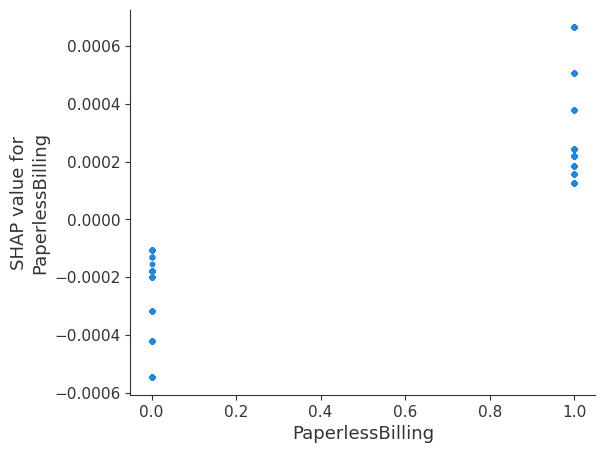

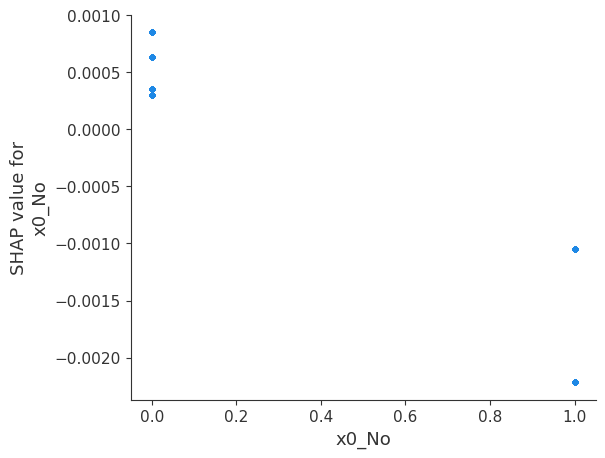

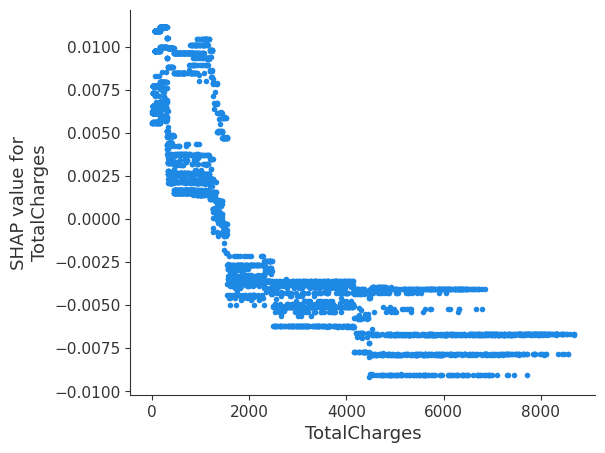

In [21]:
for feature in less_important_features:
    shap.dependence_plot(feature, shap_values[:,:,1], samples, interaction_index=None)

Based on the dependence plots of the top 5 to 10 important features, the customers who churn have the following additional characteristics:
- Pays a monthly charge greater than 70 currency units
- Not in a two-year or one-year contract term
- Payment method is paperless billing
- Has no internet service provider
- Total accumulated charge is less than 1000 currency units

### VIII. **Conclusion**

*Results*
<br><br>
1. What characterirstics do customers who churn (unsubscribe) have? 
- In a month-to-month contract term
- Tenure is less than 10 years
- Internet service provider is fiber optic
- Payment method is electronic check
2. What characteristics do customers who do not unsubscribe have?
- Not in a month-to-month contract term
- Tenure is greater than 10 years
- Internet service provider is not fiber optic
- Payment method is not electronic check

<br><br>
*Recommendation*
<br><br>
3. Based on the results of the classification model, what can be done to prevent telco customers from unsubscribing?
<br><br>
Considering that having a month-to-month contract term covers more than 40% of the explainability of the classification model, which means that it significantly influences telco customers to churn or unsubscribe. It is suggested to adjust the contract term for telco subscription plans to a longer period to retain customers and have a continuous flow of income for a lengthier period. This is supported by the low percentage of explainability of the one year and two years contract terms that constitutes to less than 8% of the explainability of the model, which means it influences customers to unsubscribe on a lower magnitude compared to the month-to-month contract term feature. Therefore, experimenting with a longer contract term more than a month would be an effective way to decrease customer churn and increase profitability from telco subscription plans.

### IX. **Reference**
1. Shopenova, A. (2023). Interpret_random_forest_classifier_using_SHAP. GitHub. https://github.com/aig3rim/Interpret_random_forest_classifier_using_SHAP